# Portfolio Backtesting

In [48]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime

from time import sleep

import quandl

import seaborn as sns

import sys
from scipy.stats import norm
import ezodf

## Functions

In [49]:
def port_eval(port, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
 
    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,3)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),3)
        sortino = round(cagr/sortino,3)
        sharpe = round(cagr/vol,3)
        
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,3)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
    
    SWR = round(MAX_SWR(cagr, vol, 30), 4)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0])),
                                 float(SWR.iloc[0])]},
                   index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR', 'SWR'])
    

    
    return metrics

In [50]:
def MAX_SWR(CAGR, VOL, T):
    MAX_SWR = CAGR - (1.96*VOL*np.sqrt(T))/T
    
    return MAX_SWR

In [51]:
def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [52]:
def wrangle(assets, data_freq, lookback_period):
    data = pd.concat(assets, axis = 1)
    data = data.ffill()
    data = data.dropna()
    data = data/data.shift()
    data = data.fillna(1)
    data = data.ffill()
    if data_freq == 'M':
        data = data[-lookback_period*12:]
    elif data_freq == 'D':
        data = data[-lookback_period*252:]
        
    data_names = data.columns.tolist() 
        
    return (data, data_names)

In [53]:
def backtest_strategy(data, W, tol, rebalance_freq, data_names, leverage = 1):
    initial = 1
    asset = [i * initial for i in W]
    port = []
    port_W = [] 

    if 0.999 < sum(W) < 1.001:

        for i in range(len(data)):
            #port.append(initial)
            port_W.append([i / initial for i in asset])
            
            daily_ret = ((data.iloc[i]-1) * leverage) +1
            asset = asset * daily_ret #data.iloc[i]
            initial = sum(asset)
            port.append(initial)
            #Rebalancing by days
            if i%rebalance_freq == 0:
                for i in range(len(W)):
                    asset[i] = initial * W[i]
            
            #Rebalancing by deviation
            for i in range(len(asset)):
                if abs(asset[i]/initial - W[i])> tol:  
                      asset = [i * initial for i in W]
    
        port = pd.DataFrame(port)
        port.index = data.index
    
        result = pd.concat([port, data.cumprod()], axis =1)
        result.columns = ["Portfolio"] + data_names
        
        return (result, port_W)
        
    else:
        print("Weight not Equal to 1!")

In [54]:
def strategy_evaluation(result, data_names, freq = 'D'):
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    th_props = [
  ('font-size', '20px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '20px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(metrics.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(metrics.columns), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino','SWR'],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.1%}", 'Max DD': "{:.0%}", 'Volatility': "{:.1%}", 'SWR':"{:.1%}", 'Sharpe': "{:.2f}",
              'Sortino': "{:.2f}", 'MAR': "{:.2f}"})
      .set_table_styles(styles))
    
    return metrics


In [55]:
def plot(result, scale):
    sns.set_style("darkgrid");
    plt.figure(figsize=(20,10));
    for i in result.columns:
        plt.plot(result[i], label = i);

    start = datetime.date(result.index.min());
    end = datetime.date(result.index.max());
    if scale == "log":
        plt.yscale("log")
        plt.ylabel('Log Return', fontsize=18)
    else: 
        plt.ylabel('Linear Return', fontsize=18)
    plt.legend(loc=2, prop={'size': 20});
    plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)

In [56]:
def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    corr = round(corr, 3)
    th_props = [
      ('font-size', '20px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '20px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .format("{:.2f}")
          .set_table_styles(styles))
    
    return corr

In [57]:
def bond_return(filename, sheet_no=0, header=0):
    '''10 YEAR BOND RETURN. sheet1:Original US, sheet2: Improved US, sheet3:germany, 
    sheet4:Japan, sheet5:Australia, sheet6:Norway. sheet7:Sweden'''
    
    tab = ezodf.opendoc(filename="../Data/"+filename).sheets[sheet_no]
    temp_data= pd.DataFrame({col[header].value:[x.value for x in col[header+1:]]
                         for col in tab.columns()})
    temp_data['observation_date'] = pd.to_datetime(temp_data['observation_date'], errors='coerce')
    temp_data.index = temp_data['observation_date']
    bond_ret = pd.DataFrame(temp_data['Cum Ret'])
    bond_ret = bond_ret.dropna()
    bond_ret.columns = ['10Y Bond']
    return(bond_ret)

## Data Imports and Wrangling

All monthly data are set to first day of every month. 

In [58]:
# SP500
SP500_daily_tmp = yf.download("^SP500TR")
SP500_daily= pd.DataFrame(SP500_daily_tmp['Close'])
SP500_daily.columns = ['SP500']

SP500_monthly = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="6rNSyTM5R4g7_B7XSyQW")
SP500_monthly.columns = ['SP500']

# Gold
Gold_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")
Gold_daily = pd.DataFrame(Gold_tmp["USD (AM)"])
Gold_daily.columns = ['Gold']

Gold_monthly = Gold_daily.resample('M').last()
Gold_monthly.columns = ['Gold']
Gold_monthly.index = Gold_monthly.index + pd.Timedelta('1 day')

# 3 year US Government Bond
SHY_daily_tmp = yf.download("SHY")
SHY_daily = pd.DataFrame(SHY_daily_tmp['Close'])
SHY_daily.columns = ['SHY']

SHY_monthly = SHY_daily.resample('M').last()
SHY_monthly.index = SHY_monthly.index + pd.Timedelta('1 day')

# 10 year US Government bond
path = 'International Monthly Government Bond Returns.ods'
Bond_monthly = bond_return(filename=path, sheet_no = 2)
Bond_monthly.index = Bond_monthly.index + pd.Timedelta('1 day')


# 20 year US Treasury Bond
TLT_daily_tmp =  yf.download("TLT")
TLT_daily = pd.DataFrame(TLT_daily_tmp['Close'])
TLT_daily.columns = ['TLT']

TLT_monthly = TLT_daily.resample('M').last()
TLT_monthly.index = TLT_monthly.index + pd.Timedelta('1 day')

# Trend Following
%run TF_Data.ipynb

# Long Vol
long_vol_imp = pd.read_excel (r'https://www.eurekahedge.com/Indices/ExportIndexReturnsToExcel?IndexType=Eurekahedge&IndexId=640')

long_vol = long_vol_imp[3:]
long_vol.index= pd.to_datetime(long_vol_imp[3:]['Unnamed: 0'])
long_vol = pd.DataFrame(long_vol['Unnamed: 2'])
long_vol.columns = ["Long Vol"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Parameters for backtest
**Available assets**: 

Daily: SP500_daily, Gold_daily, SHY_daily, TLT_daily

Monthly: SP500_monthly, Gold_monthly, SHY_monthly, Bond_monthly, TLT_monthly, long_vol 

In [59]:
lookback_period = 60 # in years
data_freq = 'M' # 'M' for monthly, 'D' for daily
rebalance_freq = 3 # in monthy for monthtly, days for daily
tol = 0.1 # trigger for rebalancing
assets = [SP500_monthly, Gold_monthly, Bond_monthly, TF_monthly] 
leverage = 1
w = [0.30, 0.20, 0.30, 0.20]

## Backtest

In [60]:
data, data_names = wrangle(assets, data_freq, lookback_period)

res, weights = backtest_strategy(data, w, tol, rebalance_freq, data_names, leverage)
strategy_evaluation(res, data_names, freq = data_freq)

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,SWR
Portfolio,10.4%,8.1%,1.28,2.08,-18%,0.58,7.5%
SP500,7.2%,12.6%,0.58,0.66,-51%,0.14,2.7%
Gold,8.1%,19.6%,0.41,0.68,-62%,0.13,1.1%
10Y Bond,6.8%,7.9%,0.86,1.37,-16%,0.43,4.0%
TF,18.7%,19.9%,0.94,1.34,-27%,0.69,11.6%


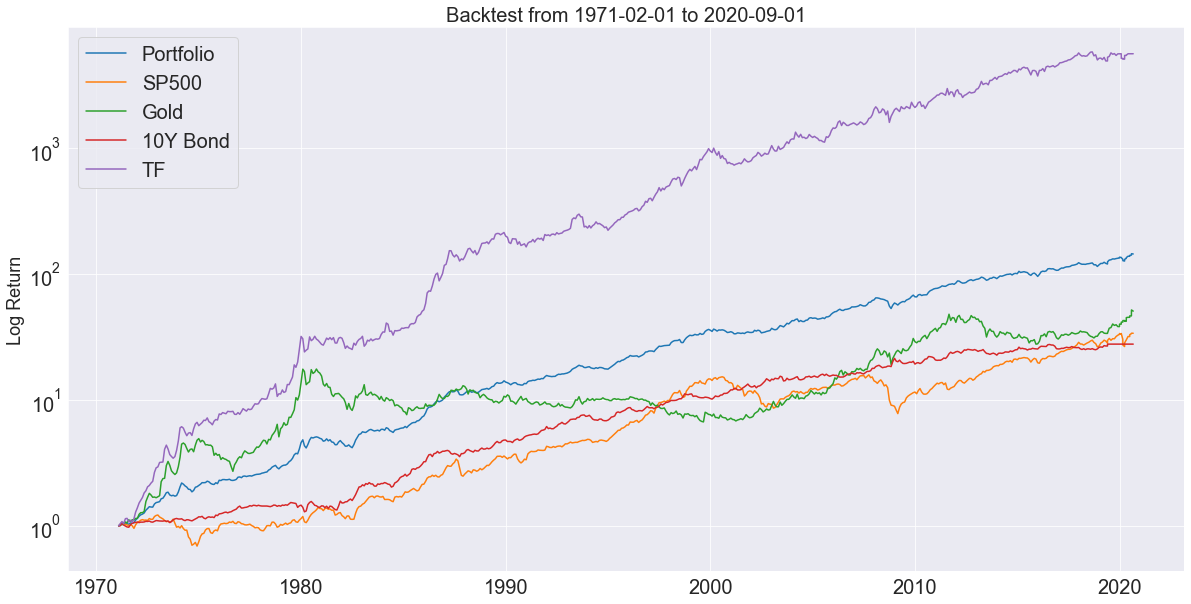

In [61]:
plot(res, "log") # "log" for log otherwise "" for lin

In [62]:
correlation_map(res)

,Portfolio,SP500,Gold,10Y Bond,TF
Portfolio,1.00,0.60,0.50,0.46,0.67
SP500,0.60,1.00,-0.04,0.16,0.25
Gold,0.50,-0.04,1.00,0.05,0.02
10Y Bond,0.46,0.16,0.05,1.00,0.14
TF,0.67,0.25,0.02,0.14,1.00
